In [1]:
# spacy will be used for lemmatization and stop words removal it's better than nltk
!pip install spacy

Defaulting to user installation because normal site-packages is not writeable


In [22]:
# Data analysis 
import pandas as pd

# Data plotting
import matplotlib.pyplot as plt
import seaborn as sn

# Text analysis
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import emoji
import emot
import contractions
import string
import nltk
from nltk.stem import SnowballStemmer 
from nltk.tokenize import word_tokenize

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Save model
import joblib

import time

# Loading data

In [61]:
reviews = pd.read_csv('/home/verpen/Downloads/Datasets/Amazon_Reviews_4M/train.csv')

In [62]:
reviews

,Review,Label
0,Stuning even for the non-gamer: This sound tra...,2
1,The best soundtrack ever to anything.: I'm rea...,2
2,Amazing!: This soundtrack is my favorite music...,2
3,Excellent Soundtrack: I truly like this soundt...,2
4,"Remember, Pull Your Jaw Off The Floor After He...",2
...,...,...
3599995,Don't do it!!: The high chair looks great when...,1
3599996,"Looks nice, low functionality: I have used thi...",1
3599997,"compact, but hard to clean: We have a small ho...",1
3599998,what is it saying?: not sure what this book is...,1


# Data analysis


### Analysis of the dataset

In [63]:
reviews['Label'].value_counts()

2    1800000
1    1800000
Name: Label, dtype: int64

In [66]:
# Choose a random subset from the dataset with equal number of 
# positive and negative tweets
subset = 50000
pos_subset = reviews[reviews['Label'] == 2].sample(subset)
neg_subset = reviews[reviews['Label'] == 1].sample(subset)

modified_data = pd.concat([pos_subset, neg_subset])

In [7]:
# modified_data.to_csv('/home/verpen/Downloads/Datasets/Amazon_Review_100k.csv')
modified_data = pd.read_csv('/home/verpen/Downloads/Datasets/Amazon_Review_100k.csv')

In [8]:
modified_data.sample(5)

,Unnamed: 0,Review,Label,Tokens,String_tokens
23948,23948,Always a good read. Nice to have it on Kindle....,2,"['good', 'read', 'nice', 'kindl', 'good', 'ins...",good read nice kindl good insight dickson dors...
66975,66975,Seriously?: I saw the other reviews for this a...,1,"['serious', 'saw', 'review', 'not', 'believ', ...",serious saw review not believ spin doctor wors...
40884,40884,This is a wonderful collection of songs: I was...,2,"['wonder', 'collect', 'song', 'given', 'gift',...",wonder collect song given gift enjoy long time...
73854,73854,Not A Workout Video: I was looking for a dance...,1,"['not', 'workout', 'video', 'look', 'danc', 't...",not workout video look danc type workout video...
35079,35079,"C + Bio-Fizz is Awesome: I love this product, ...",2,"['bio', 'fizz', 'awesom', 'love', 'product', '...",bio fizz awesom love product not up charg orde...


# Data Preprocessing

In [68]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "1st" : "first", 
    "2nd" : "second", 
    "3rd" : "third",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "canx" : "cancel",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dnt" : "don't",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "emerg" : "emergency",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "haha" : "laugh", 
    "hahaha" : "laugh", 
    "hehe" : "laugh", 
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrs" : "hour",
    "hrh" : "his royal highness",    
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pls" : "please",
    "plz" : "please",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rite" : "right",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sry" : "sorry",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thank" : "thank",
    "thanks" : "thank",
    "thks" : "thank",
    "tho" : "though",
    "thx" : "thank",
    "tia" : "thanks in advance",
    "til" : "until",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "us" : "united states",
    "usa" : "united states",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "ya" : "you",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

# This abbreviation list is by @nmaguette from Kaggle

In [69]:
def expand_abbreviation(text):
    """ This function takes an abbreviated string
        and returns the expanded version with whitespace 
        replaced by underscore """
    
    expanded_abbr = ''
    expanded_text = ''
    for word in text:
        expanded_abbr = word
        if word in abbreviations: 
            expanded_abbr = abbreviations[word]
            expanded_abbr = expanded_abbr.replace(' ', '_')          
        
        expanded_text = expanded_text + expanded_abbr + " "
    
    return expanded_text

In [70]:
emot_obj = emot.core.emot()  

In [71]:
def emoj_emot_to_text(text):
    """ This function converts emojis and emoticons to corresponding text """
    
    # Emoticons  
    emoticons_list = emot_obj.emoticons(text)['mean']
    for emoticon in emoticons_list: 
        emoticon = emoticon.replace(', ', ' ')
        emoticon = emoticon.replace(' ', '_')
        text = text + emoticon + " "       
    
    
    # Emojis
    text = emoji.demojize(text) 
    text = re.sub(':', '', text)
    return text

In [83]:
stop_words = list(STOP_WORDS)

# Exclude from stop words list the following negative words
stop_words.remove('not')
stop_words.remove('never')
stop_words.remove('none')
stop_words.remove('noone')
stop_words.remove('neither')
stop_words.remove('cannot')

In [84]:
def remove_trivial_words(text):  
    """ This function Removes stopwords and words with length of one character or two """
    
    temp = ""
    for word in text.split():
        if  word not in stop_words:
            if len(word) != 1 and len(word) != 2:
                temp += word + " "
    return temp

In [116]:
# Stemming
snowballStemmer = SnowballStemmer(language='english') 

def preprocess_texts(text): 
    
    #     Preprocess texts
    text = text.lower() # Convert to lower case
    text = contractions.fix(text) # Remove contractions
    
    #     Remove insignificant characters using regex
    text = re.sub('\S+@\S+.\S+', '', text) # Remove emails
    text = re.sub('@[\S]+', '', text) # Remove mentions starting with @       
    text = re.sub('(http|https):\/\/[\S]*', '', text) # Remove links starting with http or https
    text = re.sub('#+\S*|\.+', '', text) # Remove Hashtags and dots
    text = re.sub(r'(.)\1{2,}', r'\1', text) # Remove characters repetition
    text = re.sub(r'&[\S]+;', '', text) # Remove html tags, such as &amp;  
    text = re.split('(\W+)', text) # Insert a space between characters and punctuations
       
    # Expand abbreviations
    text = expand_abbr(text)   
    
    # Emojis and Emoticons
    text = emoj_emot_to_text(text)      
    
    text = re.sub('\W', ' ', text)  # Remove remaining punctuations  
    text = re.sub('\d', '', text)  # Remove Numbers    
   
    # Remove trivial words
    text = remove_trivial_words(text)
    
    # Stemming    
    stemmed_token_list = [] 
    for token in text.split(): 
        stemmed_token_list.append(snowballStemmer.stem(token))

    return stemmed_token_list #Return processed text as a list

In [118]:
modified_data['Tokens'] = modified_data['Review'].apply(preprocess_texts)

Time: 300.9032441189993s


In [119]:
modified_data

,Review,Label,Tokens
910501,Unlike anything else: I bought this CD after h...,2,"[unlik, bought, hear, second, miss, bittova, m..."
152113,Thrilled it's on Kindle: I have been in love w...,2,"[thrill, kindl, love, seri, year, year, time, ..."
3016985,Great tool but NO organizer for accessories is...,2,"[great, tool, organ, accessori, annoy, chose, ..."
3581694,My rating: Merchandise was delivered in about ...,2,"[rate, merchandis, deliv, day, good, condit, c..."
26204,FUNNY: I still think this is one of the funnie...,2,"[funni, think, funniest, movi, seen, probabl, ..."
...,...,...,...
2233284,This CD is the lamest one ever.: None of the s...,1,"[lamest, none, song, slight, hint, moral, not,..."
1586163,Laurel & Hardy steal the show in this crazy ho...,1,"[laurel, hardi, steal, crazi, hodgepodg, appli..."
2301814,Exploded my pipes: I installed a Titan SRC-2 a...,1,"[explod, pipe, instal, titan, src, year, ago, ..."
2043308,Terrible....: These three papyrus plants looke...,1,"[terribl, papyrus, plant, look, sprout, seed, ..."


In [120]:
# Convert token lists to string 
def convert_list_str(tokens):
    return ' '.join(tokens)
modified_data['String_tokens'] = modified_data['Tokens'].apply(convert_list_str)

In [121]:
modified_data = modified_data.reset_index(drop=True)
modified_data

,Review,Label,Tokens,String_tokens
0,Unlike anything else: I bought this CD after h...,2,"[unlik, bought, hear, second, miss, bittova, m...",unlik bought hear second miss bittova music np...
1,Thrilled it's on Kindle: I have been in love w...,2,"[thrill, kindl, love, seri, year, year, time, ...",thrill kindl love seri year year time print no...
2,Great tool but NO organizer for accessories is...,2,"[great, tool, organ, accessori, annoy, chose, ...",great tool organ accessori annoy chose dremel ...
3,My rating: Merchandise was delivered in about ...,2,"[rate, merchandis, deliv, day, good, condit, c...",rate merchandis deliv day good condit complain...
4,FUNNY: I still think this is one of the funnie...,2,"[funni, think, funniest, movi, seen, probabl, ...",funni think funniest movi seen probabl mood wa...
...,...,...,...,...
99995,This CD is the lamest one ever.: None of the s...,1,"[lamest, none, song, slight, hint, moral, not,...",lamest none song slight hint moral not recommend
99996,Laurel & Hardy steal the show in this crazy ho...,1,"[laurel, hardi, steal, crazi, hodgepodg, appli...",laurel hardi steal crazi hodgepodg appli star ...
99997,Exploded my pipes: I installed a Titan SRC-2 a...,1,"[explod, pipe, instal, titan, src, year, ago, ...",explod pipe instal titan src year ago thing ne...
99998,Terrible....: These three papyrus plants looke...,1,"[terribl, papyrus, plant, look, sprout, seed, ...",terribl papyrus plant look sprout seed day shi...


# Analyze data after processing

In [9]:
# Count the number of tokens in the dataset after processing
num_unique_tokens = 0
num_of_total_tokens = 0
num_pos_tokens = 0
num_neg_tokens = 0
pos_tokens = []
neg_tokens = []
rows = modified_data.shape[0]

for i in range(rows):
    if modified_data['Label'][i] == 1:
        for token in modified_data['Tokens'][i]:
            neg_tokens.append(token)    
    else:
        for token in modified_data['Tokens'][i]:
            pos_tokens.append(token)     

num_pos_tokens = len(pos_tokens)
num_neg_tokens = len(neg_tokens)
num_of_total_tokens = num_pos_tokens + num_neg_tokens
num_unique_tokens = len(set(pos_tokens)) + len(set(neg_tokens))

print(f"""Number of tokens: {num_of_total_tokens}
Number of unique tokens: {num_unique_tokens}
Positive Tokens: {num_pos_tokens}
Negative Tokens: {num_neg_tokens}
Positive Unique Tokens: {len(set(pos_tokens))}
Negative Unique Tokens: {len(set(neg_tokens))}""")

Number of tokens: 32195512
Number of unique tokens: 89
Positive Tokens: 15661839
Negative Tokens: 16533673
Positive Unique Tokens: 44
Negative Unique Tokens: 45


In [10]:
# Calculate words occurances 
def occurances_of_words(dataframe, reverse=True):
    freq_words_dic = {}
    rows = dataframe.shape[0]
    
    for i in range(rows):
        for word in dataframe['Tokens'][i]:
            if word in freq_words_dic:
                freq = freq_words_dic[word]
                freq_words_dic[word] = freq + 1
            else:
                freq_words_dic[word] = 1
    return sorted(freq_words_dic.items(), key=lambda x: x[1], reverse=reverse)

In [11]:
# Calculate words occurances in negative tweets
neg_modified_data = modified_data[modified_data['Label'] == 1]
neg_modified_data = neg_modified_data.reset_index(drop=True)

neg_freq_words = occurances_of_words(neg_modified_data)
sorted(neg_freq_words, key=lambda x: x[1], reverse=True)[:20]

[("'", 3625868),
 (',', 1762934),
 (' ', 1762934),
 ('e', 920748),
 ('t', 798190),
 ('o', 796523),
 ('r', 716168),
 ('a', 711149),
 ('i', 690661),
 ('n', 612483),
 ('s', 495805),
 ('l', 451690),
 ('c', 384455),
 ('d', 346261),
 ('p', 320842),
 ('u', 308293),
 ('m', 271139),
 ('h', 257095),
 ('b', 210655),
 ('g', 207267)]

In [12]:
# Calculate words occurances in positive tweets
pos_modified_data = modified_data[modified_data['Label'] == 2]
pos_modified_data = pos_modified_data.reset_index(drop=True)

pos_freq_words = occurances_of_words(pos_modified_data)
sorted(pos_freq_words, key=lambda x: x[1], reverse=True)[:20]

[("'", 3412558),
 (',', 1656279),
 (' ', 1656279),
 ('e', 934973),
 ('o', 724009),
 ('t', 712154),
 ('a', 694989),
 ('r', 684733),
 ('i', 674537),
 ('n', 548009),
 ('s', 460214),
 ('l', 457778),
 ('c', 373683),
 ('d', 330905),
 ('u', 278652),
 ('p', 266319),
 ('m', 266287),
 ('h', 248916),
 ('g', 226569),
 ('b', 194088)]

In [13]:
def plot_ten_freq_words(freq_words_list, label, color):
    """ Plot a bar chart with the ten most frequent words """
    
    ten_freq_words = [f_item[0] for f_item in freq_words_list]
    occurances = [s_item[1] for s_item in freq_words_list]    
    
    # X ticks position
    x_pos = [x*2 for x in range(10)]

    plt.bar(x_pos, occurances, align='center', width=1.5, alpha=0.8, color=color, label=label)
    plt.xlabel('Most Frequent Words')
    plt.ylabel('Number of occurances')
    plt.legend()
    plt.xticks(x_pos, ten_freq_words, rotation='vertical')
    plt.show()

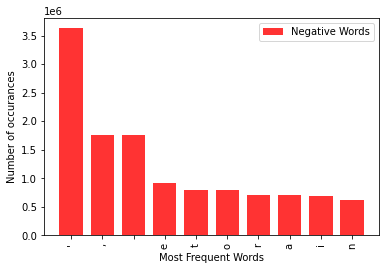

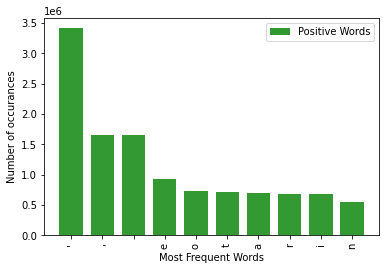

In [14]:
ten_neg_freq_words = neg_freq_words[:10]
ten_neg_freq_words
plot_ten_freq_words(ten_neg_freq_words, 'Negative Words', 'red')
ten_pos_freq_words = pos_freq_words[:10]
ten_pos_freq_words
plot_ten_freq_words(ten_pos_freq_words, 'Positive Words', 'green')

# Feature Extraction and Model Training

In [19]:
X_train, y_test = train_test_split(modified_data, test_size=0.2, random_state = 0)
print(f'Splitted data: \nTrain Dimensions: {X_train.shape}\nTest Dimensions: {y_test.shape}\n')

tfidf = TfidfVectorizer(ngram_range=(1, 2))
tfidf.fit(X_train['String_tokens'])
trained_tfidf = tfidf.transform(X_train['String_tokens'])
test_tfidf = tfidf.transform(y_test['String_tokens'])
print(f'Fitted data: \nTrain Dimensions: {trained_tfidf.shape}\nTest Dimensions: {test_tfidf.shape}')

Splitted data: 
Train Dimensions: (80000, 5)
Test Dimensions: (20000, 5)

Fitted data: 
Train Dimensions: (80000, 1535420)
Test Dimensions: (20000, 1535420)


In [16]:
def plot_model(model, y_test):      
    # Print classfification report
    predictions = model.predict(test_tfidf)
    print(classification_report(y_test['Label'], predictions))
    
    # Print and plot confusion matrix
    cm = confusion_matrix(y_test['Label'], predictions, labels=[1, 2])
    print(cm)
    plt.figure(figsize= (10, 7))
    sn.heatmap(cm, annot=True, fmt='.0f')
    plt.xlabel('Predicted')
    plt.ylabel('value')
    plt.show()

### Logistic Regression

In [17]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(trained_tfidf, X_train['Label'])
log_model.score(test_tfidf, y_test['Label'])

0.886

In [18]:
score = cross_val_score(log_model, trained_tfidf, X_train['Label'], cv=10, scoring='accuracy')
print(f'Average accuracy: {score.mean()}')

Average accuracy: 0.8862625


### SVM

In [132]:
# svm_model = SVC(kernel='linear')
# svm_model.fit(trained_tfidf, X_train['Label'])

SVC(kernel='linear')

              precision    recall  f1-score   support

           1       0.90      0.90      0.90      9956
           2       0.90      0.90      0.90     10044

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000

[[8968  988]
 [ 957 9087]]


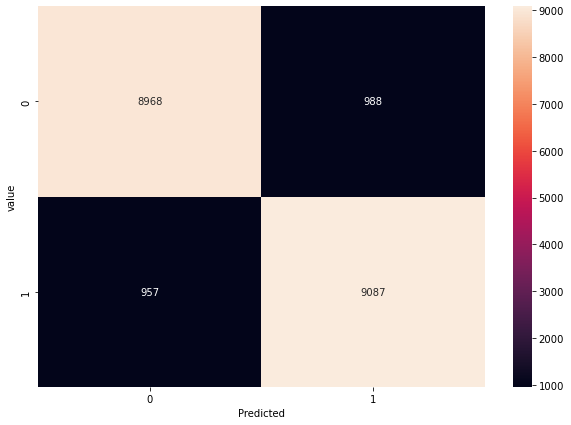

In [134]:
plot_model(svm_model, y_test)

In [135]:
svm_model.score(test_tfidf, y_test['Label'])

0.90275

In [153]:
# import pickle
# with open('/home/verpen/Downloads/Datasets/Models/SVM_Amazon_Reviews_90%_pkl', 'wb') as files:
#     pickle.dump(svm_model, files)

In [154]:
# joblib.dump(svm_model, '/home/verpen/Downloads/Datasets/Models/SVM_Amazon_Reviews_90%')

['/home/verpen/Downloads/Datasets/Models/SVM_Amazon_Reviews_90%']

In [155]:
m_jlib = joblib.load('/home/verpen/Downloads/Datasets/Models/SVM_Amazon_Reviews_90%')
m_jlib

SVC(kernel='linear')

## Decision Tree

In [20]:
dtree_model = DecisionTreeClassifier()
dtree_model.fit(trained_tfidf, X_train['Label'])

DecisionTreeClassifier()

In [21]:
dtree_model.score(test_tfidf, y_test['Label'])

0.76955

## Random Forest

In [23]:
rforest_model = RandomForestClassifier()
rforest_model.fit(trained_tfidf, X_train['Label'])

RandomForestClassifier()

In [24]:
rforest_model.score(test_tfidf, y_test['Label'])

0.86275

# Test the model 

In [136]:
def pipeline(model, test_data):
    """ This function takes a Pandas series data type as argument with two columns, 
        one column called tweet_sentiment and the other called text,
        It's hard coded just to test the model. 
    """
    # Preprocessing
    start = time.perf_counter()
    test_data['processed_tweets'] = test_data['Review'].apply(preprocess_tweets)
    test_data['string_tweets'] = test_data['processed_tweets'].apply(convert_list_str)
    end = time.perf_counter()
    
    print(f'Processing time: {end - start}')
    # Display a sample of the processed tweets 
    #test_data.sample(10)
    
    # Transform processed tweet using tfidf vectorizer initiated and fitted above
    test_tfidf = tfidf.transform(test_data['string_tweets'])
    
    # Predict
    predictions = model.predict(test_tfidf)
    print(classification_report(test_data['Label'], predictions))
    cm = confusion_matrix(test_data['Label'], predictions, labels=[1, 2])
    print(cm)
    plt.figure(figsize= (10, 7))
    sn.heatmap(cm, annot=True, fmt='.0f')
    plt.xlabel('Predicted')
    plt.ylabel('value')
    plt.show()
    
    # Plot a pie 
    (unique, counts) = np.unique(predictions, return_counts=True)
    print(f'Unique: {unique}\t\tCounts: {counts}')
    
    neg_tweets_counts = counts[0]
    pos_tweets_counts = counts[1]
    labels = ["Negative", "Positive"]
    plt.pie(counts, labels=labels, shadow=True, autopct="%1.2f%%")
    
    # Return the array that stores the predictions
    return predictions

In [49]:
def manual_testing(model, tweet):
    processed_tweets = preprocess_tweets(tweet)
    print(f'Processed Tweets: {processed_tweets}')
    
    string_tweets = convert_list_str(processed_tweets)
    print(f'String Tweets: {string_tweets}')
    
    test_tfidf = tfidf.transform([string_tweets])
    prediction = model.predict(test_tfidf)
    
    if prediction == 2: 
        return 'Positive'
    else:
        return 'Negative'

In [149]:
manual_testing(svm_model, "This movie is not good")

Processed Tweets: ['movi', 'not', 'good']
String Tweets: movi not good


'Negative'

# Model testing with Amazon Reviews dataset

In [51]:
# Another test
test_data_2 = pd.read_csv('/home/verpen/Downloads/Datasets/Amazon_Reviews_4M/test.csv') # 400k reviews
test_data_2 = test_data_2.sample(100000)
test_data_2 = test_data_2.reset_index(drop=True)
test_data_2

,Review,Label
0,So difficult!: Assumes a level of card experti...,1
1,Brave New Girl: Although the thinking of this ...,1
2,The absolute BEST!: The only thing wrong with ...,2
3,I'd rather keep my old remotes: Using a univer...,1
4,easy cleanup: These wipes are very strong and ...,2
...,...,...
99995,bad video: James Earl Jones butchers the narra...,1
99996,Wake-Up Call for Traditional Marketing Literat...,2
99997,Grisham has returned to respectable writing: G...,2
99998,Kate Thompson's best book.: I've read 8 books ...,2


Processing time: 117.00980448900009
              precision    recall  f1-score   support

           1       0.88      0.87      0.88     49796
           2       0.88      0.88      0.88     50204

    accuracy                           0.88    100000
   macro avg       0.88      0.88      0.88    100000
weighted avg       0.88      0.88      0.88    100000

[[43531  6265]
 [ 5888 44316]]


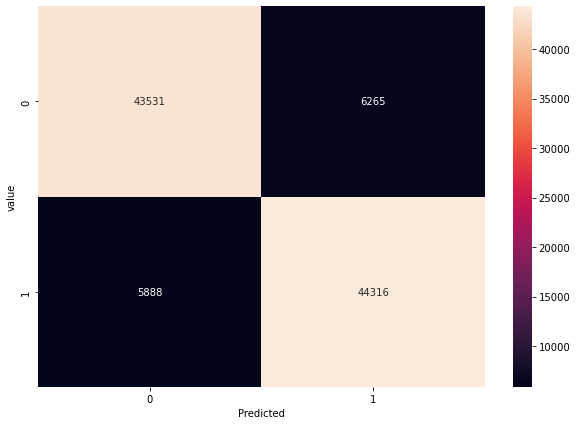

Unique: [1 2]		Counts: [49419 50581]


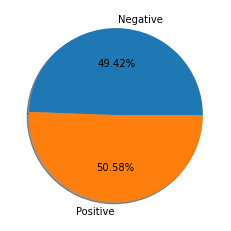

In [52]:
predics = pipeline(svm_model, test_data_2)

# Model testing with IMDb Moview Reviews dataset

In [144]:
movie_reviews_data = pd.read_csv('/home/verpen/Downloads/Datasets/imdb/IMDb_Moview_Reviews.zip')
movie_reviews_data = movie_reviews_data.rename(columns={'review':'Review', 
                                                        'sentiment': 'Label'})
movie_reviews_data

,Review,Label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [145]:
movie_reviews_data['Label'] = movie_reviews_data['Label'].apply(lambda x: 2 if x == 'positive' else 1)
movie_reviews_data

,Review,Label
0,One of the other reviewers has mentioned that ...,2
1,A wonderful little production. <br /><br />The...,2
2,I thought this was a wonderful way to spend ti...,2
3,Basically there's a family where a little boy ...,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",2
...,...,...
49995,I thought this movie did a down right good job...,2
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",1
49997,I am a Catholic taught in parochial elementary...,1
49998,I'm going to have to disagree with the previou...,1


Processing time: 329.92416962100106
              precision    recall  f1-score   support

           1       0.84      0.89      0.86     25000
           2       0.89      0.82      0.85     25000

    accuracy                           0.86     50000
   macro avg       0.86      0.86      0.86     50000
weighted avg       0.86      0.86      0.86     50000

[[22335  2665]
 [ 4388 20612]]


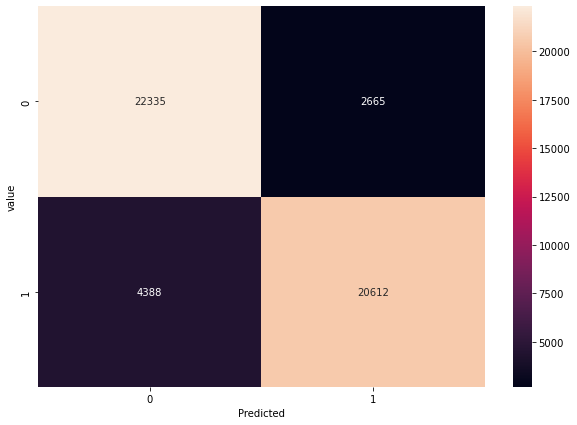

Unique: [1 2]		Counts: [26723 23277]


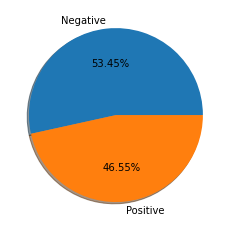

In [146]:
predics = pipeline(svm_model, movie_reviews_data)